In [2]:
import numpy as np
import cv2

# Define the objective function (fitness function) for image enhancement
# Here, we aim to maximize image entropy and edge intensity
def objective_function(params, image):
    alpha, beta = params
    
    # Apply contrast stretching (example enhancement)
    enhanced_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    # Calculate fitness: maximize entropy and edge intensity
    # A more sophisticated fitness function could be used for specific tasks
    entropy = -np.sum(np.histogram(enhanced_image, bins=256, range=(0, 256))[0] / (enhanced_image.size + 1e-10) * np.log2(np.histogram(enhanced_image, bins=256, range=(0, 256))[0] / (enhanced_image.size + 1e-10) + 1e-10))
    edges = cv2.Canny(enhanced_image, 100, 200)
    edge_intensity = np.sum(edges) / (edges.size + 1e-10)
    
    # We want to maximize, so we return a positive value
    return entropy + edge_intensity

# Particle Swarm Optimization algorithm
def pso_image_enhancement(image, num_particles=20, max_iterations=10, 
                          c1=2, c2=2, w=0.7, 
                          param_bounds=[(0.5, 3.0), (0, 100)]): # Bounds for alpha, beta

    num_dimensions = len(param_bounds)
    
    # Initialize particles
    particles = np.zeros((num_particles, num_dimensions))
    velocities = np.zeros((num_particles, num_dimensions))
    personal_best_positions = np.zeros((num_particles, num_dimensions))
    personal_best_scores = np.full(num_particles, -np.inf) # Initialize with negative infinity for maximization
    
    global_best_position = np.zeros(num_dimensions)
    global_best_score = -np.inf

    for i in range(num_particles):
        for d in range(num_dimensions):
            particles[i, d] = np.random.uniform(param_bounds[d][0], param_bounds[d][1])
        personal_best_positions[i] = particles[i].copy()
        personal_best_scores[i] = objective_function(particles[i], image)
        
        if personal_best_scores[i] > global_best_score:
            global_best_score = personal_best_scores[i]
            global_best_position = personal_best_positions[i].copy()

    # PSO iterations
    for iteration in range(max_iterations):
        for i in range(num_particles):
            # Update velocity
            r1 = np.random.rand(num_dimensions)
            r2 = np.random.rand(num_dimensions)
            velocities[i] = (w * velocities[i] +
                             c1 * r1 * (personal_best_positions[i] - particles[i]) +
                             c2 * r2 * (global_best_position - particles[i]))
            
            # Update position
            particles[i] += velocities[i]
            
            # Apply bounds to particle positions
            for d in range(num_dimensions):
                particles[i, d] = np.clip(particles[i, d], param_bounds[d][0], param_bounds[d][1])

            # Evaluate fitness
            current_score = objective_function(particles[i], image)
            
            # Update personal best
            if current_score > personal_best_scores[i]:
                personal_best_scores[i] = current_score
                personal_best_positions[i] = particles[i].copy()
            
            # Update global best
            if current_score > global_best_score:
                global_best_score = current_score
                global_best_position = particles[i].copy()

        print(f"Iteration {iteration+1}/{max_iterations}, Global Best Score: {global_best_score:.4f}, Global Best Params: {global_best_position}")

    return global_best_position, global_best_score

# Example usage:
if __name__ == "__main__":
    # Load an example image (replace with your image path)
    # For simplicity, creating a dummy grayscale image
    image = np.random.randint(0, 256, size=(100, 100), dtype=np.uint8)
    # image = cv2.imread('your_image.jpg', cv2.IMREAD_GRAYSCALE) 
    # if image is None:
    #     print("Error: Image not found or could not be loaded.")
    #     exit()

    print("Starting PSO for image enhancement...")
    best_params, best_score = pso_image_enhancement(image)
    print("\nPSO finished.")
    print(f"Optimal parameters (alpha, beta): {best_params}")
    print(f"Optimal fitness score: {best_score}")

    # Apply the optimal parameters to enhance the image
    optimal_alpha, optimal_beta = best_params
    enhanced_image = cv2.convertScaleAbs(image, alpha=optimal_alpha, beta=optimal_beta)

    # Display results (optional, requires a display environment)
    # cv2.imshow('Original Image', image)
    # cv2.imshow('Enhanced Image', enhanced_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

Starting PSO for image enhancement...
Iteration 1/10, Global Best Score: 103.1460, Global Best Params: [ 1.01721352 19.63471801]
Iteration 2/10, Global Best Score: 103.2815, Global Best Params: [ 1.03382995 16.72482269]
Iteration 3/10, Global Best Score: 103.2815, Global Best Params: [ 1.03382995 16.72482269]
Iteration 4/10, Global Best Score: 103.2815, Global Best Params: [ 1.03382995 16.72482269]
Iteration 5/10, Global Best Score: 103.2815, Global Best Params: [ 1.03382995 16.72482269]
Iteration 6/10, Global Best Score: 103.2815, Global Best Params: [ 1.03382995 16.72482269]
Iteration 7/10, Global Best Score: 103.2815, Global Best Params: [ 1.03382995 16.72482269]
Iteration 8/10, Global Best Score: 103.2815, Global Best Params: [ 1.03382995 16.72482269]
Iteration 9/10, Global Best Score: 103.2815, Global Best Params: [ 1.03382995 16.72482269]
Iteration 10/10, Global Best Score: 103.2815, Global Best Params: [ 1.03382995 16.72482269]

PSO finished.
Optimal parameters (alpha, beta): [ 

Running PSO algorithm...
Optimal Thresholds found: [ 90.3635092  141.40161624]


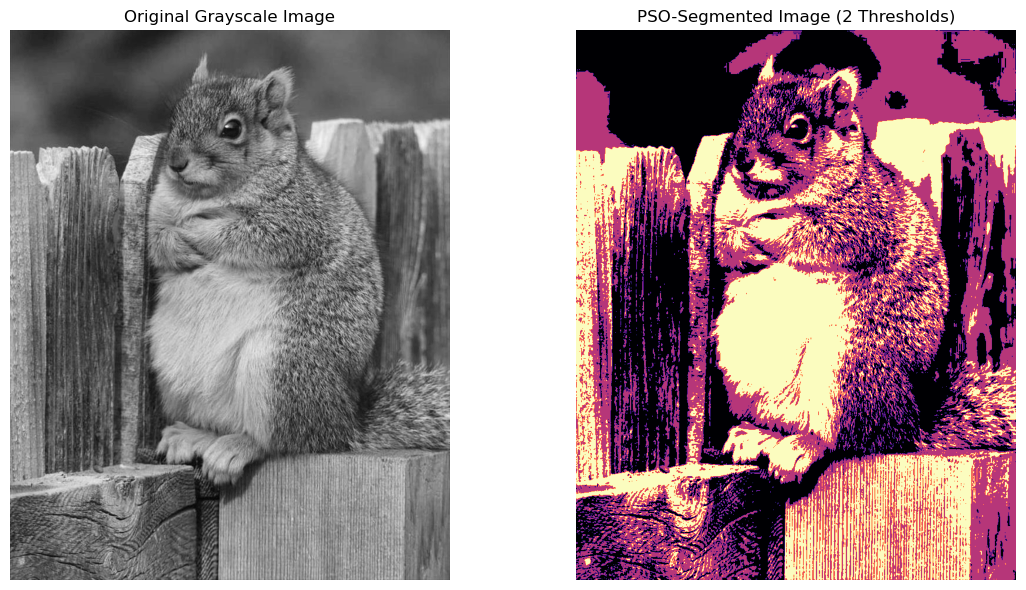

In [5]:
import numpy as np
from skimage import color
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# --- 1. Define the PSO Algorithm ---
class PSO:
    def __init__(self, obj_func, n_particles, dimensions, max_iter, bounds):
        """
        Initializes the PSO algorithm.
        """
        self.obj_func = obj_func
        self.n_particles = n_particles
        self.dimensions = dimensions
        self.max_iter = max_iter
        self.bounds = bounds

        self.w = 0.7
        self.c1 = 1.5
        self.c2 = 1.5

        # Correct way to handle multiple bounds
        low = np.array([b[0] for b in bounds])
        high = np.array([b[1] for b in bounds])

        self.positions = np.random.uniform(low, high, size=(n_particles, dimensions))
        self.velocities = np.random.uniform(-1, 1, size=(n_particles, dimensions))

        self.pbest_positions = self.positions.copy()
        self.pbest_scores = np.full(n_particles, np.inf)

        self.gbest_position = None
        self.gbest_score = np.inf

    def optimize(self):
        for i in range(self.max_iter):
            for j in range(self.n_particles):
                score = self.obj_func(self.positions[j])

                if score < self.pbest_scores[j]:
                    self.pbest_scores[j] = score
                    self.pbest_positions[j] = self.positions[j].copy()
                
                if score < self.gbest_score:
                    self.gbest_score = score
                    self.gbest_position = self.positions[j].copy()

            for j in range(self.n_particles):
                r1 = np.random.rand(self.dimensions)
                r2 = np.random.rand(self.dimensions)
                self.velocities[j] = (
                    self.w * self.velocities[j]
                    + self.c1 * r1 * (self.pbest_positions[j] - self.positions[j])
                    + self.c2 * r2 * (self.gbest_position - self.positions[j])
                )
                self.positions[j] += self.velocities[j]
                for d in range(self.dimensions):
                    self.positions[j, d] = np.clip(
                        self.positions[j, d], self.bounds[d][0], self.bounds[d][1]
                    )
        return self.gbest_position, self.gbest_score

# --- 2. Define the Fitness Function (Multi-level Otsu) ---
def otsu_multilevel(thresholds, image_hist):
    thresholds = np.sort(thresholds)
    
    # Corrected np.concatenate line
    bins = np.concatenate([np.array([0]), thresholds, np.array([255])])
    
    total_pixels = np.sum(image_hist)
    total_mean = np.sum(np.arange(256) * image_hist) / total_pixels
    
    inter_class_variance = 0
    for i in range(len(bins) - 1):
        start, end = int(bins[i]), int(bins[i+1])
        if start >= end:
            continue
        segment_hist = image_hist[start:end]
        segment_pixels = np.sum(segment_hist)
        if segment_pixels > 0:
            segment_mean = np.sum(np.arange(start, end) * segment_hist) / segment_pixels
            probability = segment_pixels / total_pixels
            inter_class_variance += probability * ((segment_mean - total_mean)**2)
            
    return -inter_class_variance

# --- 3. Run the PSO on an image ---
if __name__ == "__main__":
    image_url = 'https://th.bing.com/th/id/R.8e632b4dbd61ffe21316d0aa8fd99717?rik=S%2fVRgWs8B1QUSA&riu=http%3a%2f%2fwww.dumpaday.com%2fwp-content%2fuploads%2f2019%2f12%2fpictures-10-2.jpg&ehk=QH5i3EAxyZYJFl0N54KuqmERNBOpDvFxygcV4nlsxsk%3d&risl=&pid=ImgRaw&r=0'
    gray_image = None
    try:
        response = requests.get(image_url)
        response.raise_for_status()
        img_pil = Image.open(BytesIO(response.content))
        image = np.array(img_pil)
        gray_image = color.rgb2gray(image)
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch image from URL: {e}")
    except Exception as e:
        print(f"Failed to load image from content: {e}")

    if gray_image is not None:
        hist, _ = np.histogram(gray_image.ravel() * 255, bins=np.arange(257))
        
        n_thresholds = 2
        bounds = [(0, 255)] * n_thresholds
        
        pso = PSO(
            obj_func=lambda t: otsu_multilevel(t, hist),
            n_particles=50,
            dimensions=n_thresholds,
            max_iter=100,
            bounds=bounds
        )
        
        print("Running PSO algorithm...")
        optimal_thresholds, min_variance = pso.optimize()
        optimal_thresholds = np.sort(optimal_thresholds)
        
        print(f"Optimal Thresholds found: {optimal_thresholds}")
        
        segmented_image = np.zeros_like(gray_image)
        thresholds_scaled = optimal_thresholds / 255.0
        
        levels = np.linspace(0, 1, n_thresholds + 2)
        for i, threshold in enumerate(thresholds_scaled):
            segmented_image[gray_image >= threshold] = levels[i+1]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        ax1.imshow(gray_image, cmap='gray')
        ax1.set_title("Original Grayscale Image")
        ax1.axis('off')
        
        ax2.imshow(segmented_image, cmap='magma')
        ax2.set_title(f"PSO-Segmented Image ({n_thresholds} Thresholds)")
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("Image loading failed, exiting.")
